In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import nashpy as nash
import os
import re

In [2]:
# https://dandrake.livejournal.com/83095.html
def compositions(n,k):
  if n < 0 or k < 0:
    return
  elif k == 0:
    # the empty sum, by convention, is zero, so only return something if
    # n is zero
    if n == 0:
      yield []
    return
  elif k == 1:
    yield [n]
    return
  else:
    for i in range(0,n+1):
      for comp in compositions(n-i,k-1):
        yield [i] + comp
        
# https://stackoverflow.com/questions/1806278/convert-fraction-to-float        
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        if type(frac_str) == bytes:
            frac_str = frac_str.decode()
        try:
            num, denom = frac_str.split('/')
        except ValueError:
            return None
        try:
            leading, num = num.split(' ')
        except ValueError:
            return float(num) / float(denom)        
        if float(leading) < 0:
            sign_mult = -1
        else:
            sign_mult = 1
        return float(leading) + sign_mult * (float(num) / float(denom))

In [21]:
def make_nfg_file(spaces, A, D):
    defender = np.array([c for c in compositions(D,spaces)])
    attacker = np.array([c for c in compositions(A, spaces)])

    M = np.zeros((len(defender),len(attacker)), dtype=int)
    for i in range(len(defender)):
        for j in range(len(attacker)):
            M[i,j] = 1 if not np.any((defender[i,:] - attacker[j,:]) < 0) else 0
            #print(i,j,M[i,j],defender[i,:], attacker[j,:])


    directory = "games"
    filename = "chipGame_n{}_A{}_D{}.nfg".format(spaces, A, D)
    # array sorcery, https://stackoverflow.com/questions/5347065/interweaving-two-numpy-arrays
    a = M.T.flatten()
    b = -M.T.flatten()
    c = np.empty((a.size + b.size,), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    zerosum_form = c
    with open(os.path.join(directory,filename),'w') as file:
        file.writelines('NFG 1 R "Chip Game"\n') 
        file.writelines(r'{ "Defender" "Attacker" } ' + '{{ {} {} }}\n'.format(len(defender),len(attacker)))
        np.savetxt(file, zerosum_form, fmt='%i')   
    return M

def get_results(spaces, A, D):
    game = 'chipGame_n{}_A{}_D{}'.format(spaces,A,D)

    filename = game + '.nfg'
    directory = 'games'
    normalFormMatrix = np.loadtxt(os.path.join(directory, filename), skiprows=2)
    with open(os.path.join(directory, filename), 'r') as file:
        file.readline()
        header = file.readline()
        pattern = re.compile(r'{.*?} { (\d*) (\d*) }.*?')
        nums = pattern.findall(header)[0]
        defender_strategies, attacker_strategies = map(int, nums)

   
    M = normalFormMatrix[::2].reshape((defender_strategies, attacker_strategies), order="F")

    filename = game + '.out'
    converters = {i:convert_to_float for i in range(defender_strategies+attacker_strategies+1)}
    equilibrium = np.genfromtxt(os.path.join(directory, filename), delimiter=',', 
                                usecols=range(1,1+defender_strategies+attacker_strategies),
                                converters =  converters)

    defenderStrat = equilibrium[0:defender_strategies]
    attackerStrat = equilibrium[defender_strategies:]

    expected_value = defenderStrat@M@attackerStrat
    
    return attackerStrat, defenderStrat, expected_value, M
    

In [25]:
# create nfg files
spaces = 3
max_attack = 15
max_defense = 15
for A in range(max_attack):
    for D in range(max_defense):
        make_nfg_file(spaces, A, D)

In [26]:
defender_wins = np.zeros((max_defense, max_attack))

for A in range(max_attack):
    for D in range(max_defense):
        attackerStrat, defenderStrat, expected_value, M = get_results(spaces, A, D)
        defender_wins[A,D] = expected_value

<IPython.core.display.Javascript object>


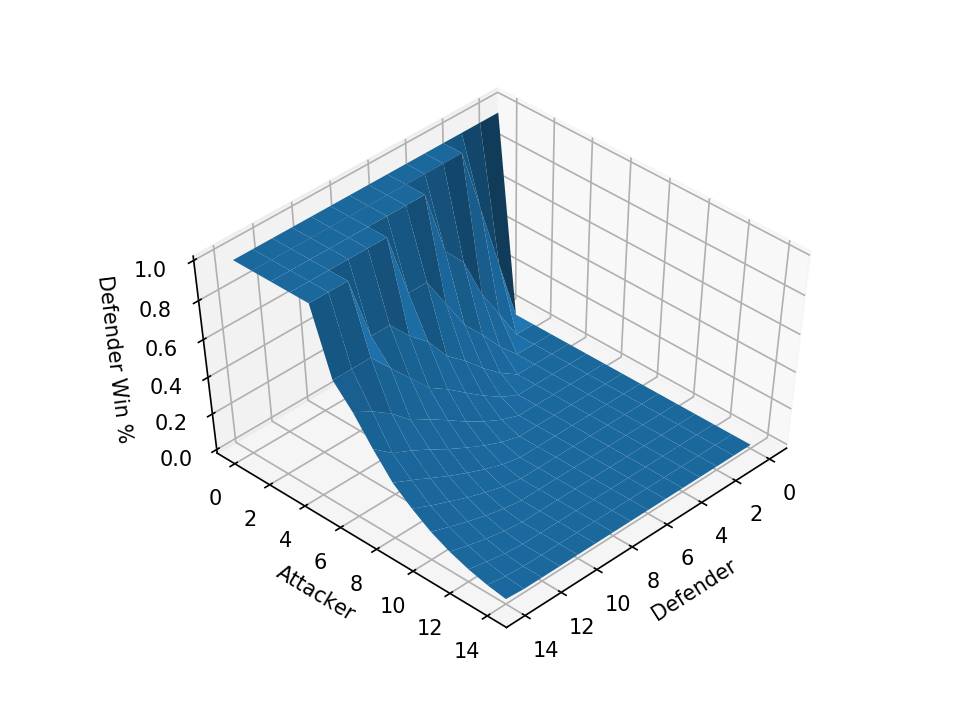

Text(0.5,0,'Defender')

In [27]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(0, max_defense)
Y = np.arange(0, max_attack)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, defender_wins)
ax.set_zlabel("Defender Win %")
ax.set_ylabel("Attacker")
ax.set_xlabel("Defender")

In [12]:
a,d,e, M,n = get_results(3,2,3)
print(a)
print(d)
print(M.T)

[ 1. -1.  1. -1.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1. -1.  1. -1.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1. -1.  0.  0.  0.  0.  1. -1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1. -1.
  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1. -1.  1. -1.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1. -1.  1. -1.  1. -1.]
[0.33333333 0.         0.33333333 0.         0.         0.33333333]
[0.         0.33333333 0.         0.         0.         0.
 0.33333333 0.33333333 0.         0.        ]
[[1. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 1.]]


In [7]:
make_nfg_file(3,2,3)

[ 1 -1  1 -1  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  1 -1
  1 -1  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  1 -1
  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  1 -1
  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  1 -1  0  0
  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  1 -1  1 -1]


array([[1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1]])

In [16]:
n[::2].reshape(len(d), len(a), order='F')

array([[1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
a

In [ ]:
M

In [ ]:
x = make_nfg_file(3,2,4)

In [ ]:
np.shape(x)

In [ ]:
converters = {i:convert_to_float for i in range(15+6+1)}
equilibrium = np.genfromtxt(os.path.join(directory, 'test.out'), delimiter=',', 
                                usecols=range(1,1+15+6),
                                converters =  converters)
defenderStrat = equilibrium[:,0:15]
attackerStrat = equilibrium[:,15:]


In [ ]:
for i in range(len(defenderStrat)):
    print(i, defenderStrat[i,:]@M@attackerStrat[i,:])

In [ ]:
print(defenderStrat[10,:])
print(attackerStrat[10,:])
print(M)

In [ ]:
np.vstack((M.T.flatten(),-M.T.flatten())).reshape((-1,),order='A')

In [ ]:
a = M.T.flatten()
b = -M.T.flatten()
c = np.empty((a.size + b.size,), dtype=a.dtype)
c[0::2] = a
c[1::2] = b
print(c)

In [ ]:
c

In [ ]:
M